In [2]:
import math
from scipy.signal import find_peaks

from mpi4py import MPI
import dolfinx
import ufl
from dolfinx import fem, io, mesh, plot, default_scalar_type, geometry, __version__ as dolfinx_version
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner

from dolfinx.fem.petsc import LinearProblem
import ufl
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
from packaging.version import Version

from petsc4py import PETSc

In [3]:
from dolfinx.fem.petsc import assemble_vector
print(PETSc.ScalarType)

<class 'numpy.complex128'>


# TEST SQUARE WITH COMPLEX NUMBERS

In [ ]:
# Define problem parameters and functions
lamb = 2
alpha_rob = np.sqrt(3)

In [ ]:
def solve_helmholtz(N = 10, degree = 2):

    # Otherwise, create it directly in fenicsx
    domain = mesh.create_rectangle(MPI.COMM_WORLD, ((0.0, 0.0), (np.pi, np.pi)),
                                [N,N], mesh.CellType.triangle)

    # Ensure connectivity
    domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

    # Define boundaries
    gamma_in = 1
    gamma_out = 2
    gamma_walls = 3
    boundaries = [(gamma_in, lambda x: np.isclose(x[0], 0)),
                (gamma_out, lambda x: np.isclose(x[0], np.pi)),
                (gamma_walls, lambda x: np.isclose(x[1], 0)),
                (gamma_walls, lambda x: np.isclose(x[1], np.pi))]

    # Identify and tag faces
    facet_indices, facet_markers = [], []
    fdim = domain.topology.dim - 1
    for (marker, locator) in boundaries:
        facets = mesh.locate_entities(domain, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    # Create meshtags obhect
    facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

    # Define ds for integration
    ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)
    V = fem.functionspace(domain, ("Lagrange", degree))
    x = ufl.SpatialCoordinate(domain)
    # Define the variational forms
    p = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    
    p_ex = ufl.cos(x[0]+ufl.pi/3)*ufl.cos(x[1]) + 1j * ufl.cos(x[0]+ufl.pi/3)*ufl.cos(x[1])
    g_N = 0.5*ufl.sqrt(3)*ufl.cos(x[1]) + 1j * 0.5*ufl.sqrt(3)*ufl.cos(x[1])

    a = (
        ufl.inner(ufl.grad(p), ufl.grad(v)) * ufl.dx
        + alpha_rob * ufl.inner(p, v) * ds(gamma_out)
        - lamb * ufl.inner(p, v) * ufl.dx
    )
    L = ufl.inner(g_N, v) * ds(gamma_in)

    # Solve problem
    p_h = fem.Function(V)
    p_h.name = "pressure"

    problem = LinearProblem(
        a,
        L,
        u=p_h,
        petsc_options={
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
        },
    )

    problem.solve()
    
    return p_h, p_ex

h: 1.25e-01, Error: 2.39e-01+0.00e+00j
h: 6.25e-02, Error: 6.59e-02+0.00e+00j
h: 3.12e-02, Error: 1.70e-02+0.00e+00j
h: 1.56e-02, Error: 4.27e-03+0.00e+00j
h: 7.81e-03, Error: 1.07e-03+0.00e+00j
h: 3.91e-03, Error: 2.68e-04+0.00e+00j
h: 1.95e-03, Error: 6.69e-05+0.00e+00j


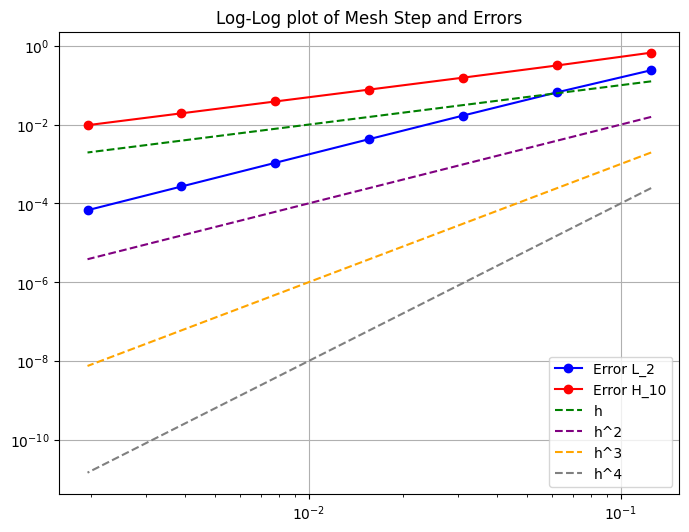

In [ ]:
Ns = [8, 16, 32, 64, 128, 256]

E_L2 = np.zeros(len(Ns), dtype=default_scalar_type)
E_H10 = np.zeros(len(Ns), dtype=default_scalar_type)
hs = np.zeros(len(Ns), dtype=np.float64)

for i, N in enumerate(Ns):
    p_h, p_ex = solve_helmholtz(N, degree=1)
    comm = p_h.function_space.mesh.comm

    # Compute errors
    error_L2 = fem.form(ufl.dot(p_h - p_ex, ufl.conj(p_h - p_ex)) * ufl.dx)
    error_H10 = fem.form(ufl.dot(grad(p_h - p_ex), ufl.conj(grad(p_h - p_ex))) * ufl.dx)

    E_L2[i] = np.sqrt(comm.allreduce(fem.assemble_scalar(error_L2), MPI.SUM))
    E_H10[i] = np.sqrt(comm.allreduce(fem.assemble_scalar(error_H10), op=MPI.SUM))
    # One can send in either u_numpy or u_ex
    # For L2 error estimations it is reccommended to send in u_numpy
    # as no JIT compilation is required
    hs[i] = 1. / Ns[i]
    if comm.rank == 0:
        print(f"h: {hs[i]:.2e}, Error: {E_L2[i]:.2e}")

# Plot results
plt.figure(figsize=(8,6))

plt.loglog(hs, E_L2, label = 'Error L_2', marker = 'o', linestyle='-', color = 'blue')
plt.loglog(hs, E_H10, label = 'Error H_10', marker = 'o', linestyle='-', color = 'red')
plt.loglog(hs, hs, label = 'h', linestyle='--', color = 'green')
plt.loglog(hs, hs**2, label = 'h^2', linestyle='--', color = 'purple')
plt.loglog(hs, hs**3, label = 'h^3', linestyle='--', color = 'orange')
plt.loglog(hs, hs**4, label = 'h^4', linestyle='--', color = 'grey')
plt.title('Log-Log plot of Mesh Step and Errors')
plt.legend()

plt.grid(True)
plt.show()

In [ ]:
with io.XDMFFile(domain.comm, "results/test1.xdmf", "w") as file:
    file.write_mesh(domain)
    file.write_function(p_h)

# CHECK MESH: LAPLACE TEST

We now want to check whether tags of the mesh are well imposed. For doing so, we construct a set of simple Laplace problems with Dirichlet boundary conditions. For each problem, one boundary at the time will be imposed to have p=1, whereas the others have p=0. We check if everything works properly.

## PROBLEM ON THE SQUARE

In [16]:
# Otherwise, create it directly in fenicsx
domain = mesh.create_rectangle(MPI.COMM_WORLD, ((0.0, 0.0), (np.pi, np.pi)),
                            [40,40], mesh.CellType.triangle)


V = fem.functionspace(domain, ("Lagrange", 1))

# Ensure connectivity
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# Define boundaries
gamma_in = 1
gamma_out = 2
gamma_walls = 3
boundaries = [(gamma_in, lambda x: np.isclose(x[0], 0)),
            (gamma_out, lambda x: np.isclose(x[0], np.pi)),
            (gamma_walls, lambda x: np.isclose(x[1], 0)),
            (gamma_walls, lambda x: np.isclose(x[1], np.pi))]

# Identify and tag faces
facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for marker, locator in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# Create meshtags obhect
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [17]:
# Mixed Dirichlet bcs
bcs = []
checked_value = 1

# p = 1 on facets with choosen tag
checked_facets = facet_tags.indices[facet_tags.values == checked_value]
checked_tag = fem.locate_dofs_topological(V, domain.topology.dim - 1,
                                          checked_facets)
bc_inhom = fem.dirichletbc(fem.Constant(domain, 1.0), checked_tag, V)
bcs.append(bc_inhom)

# p = 0 on facets with other tags
for tag in [1, 2, 3]:
    if tag != checked_value:
        facets = facet_tags.indices[facet_tags.values == tag]
        dofs = fem.locate_dofs_topological(V, domain.topology.dim - 1, facets)
        bc = fem.dirichletbc(fem.Constant(domain, 0.0), dofs, V)
        bcs.append(bc)

In [18]:
# Define the variational forms
p = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = ufl.inner(ufl.grad(p), ufl.grad(v)) * ufl.dx

f = fem.Constant(domain, PETSc.ScalarType(0.0))
L = ufl.inner(f, v) * ufl.dx

In [19]:
p_a = fem.Function(V)
p_a.name = "pressure"

problem = LinearProblem(
    a,
    L,
    bcs=bcs,
    u=p_a,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
)

problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 3), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 3)

In [20]:
with io.XDMFFile(MPI.COMM_WORLD, "solution_laplace_square.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(p_a)

## PROBLEM ON REAL MESH

In [2]:
# Load the provided mesh
msh_file = "alphorn_mesh2.msh"
domain, cell_tags, facet_tags = io.gmshio.read_from_msh(msh_file, MPI.COMM_WORLD, 0, gdim=3)

V = fem.functionspace(domain, ("Lagrange", 1))

domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

Info    : Reading 'alphorn_mesh2.msh'...
Info    : 5 entities
Info    : 59637 nodes
Info    : 63192 elements
Info    : Done reading 'alphorn_mesh2.msh'


In [3]:
# Inspect tags
if cell_tags is not None:
    print("Cell tags found:")
    print("Tag values (Physical Volumes):", np.unique(cell_tags.values))
else:
    print("No cell tags found.")

if facet_tags is not None:
    print("Tag values (Facet Tags):", np.unique(facet_tags.values))
else:
    print("No cell tags found.")

Cell tags found:
Tag values (Physical Volumes): [0]
Tag values (Facet Tags): [2 3 4 5]


In [5]:
# I do not know what these tags are referring to, and dolfinx is not importing this info:
# read mesh with meshio and look at names for tags

# Read the mesh
msh = meshio.read(msh_file)

# Print infos in the form
# {'name': [tag, dimension]}
print("Physical group names:")
print(msh.field_data)


Physical group names:
{'inlet': array([2, 2]), 'outlet': array([3, 2]), 'surface_0': array([4, 2]), 'surface_1': array([5, 2]), 'volume': array([1, 3])}


In [6]:
# Set Dirichlet Boundaries
bcs = []
checked_value = 2

# p = 1 on facets with choosen tag
checked_facets = facet_tags.indices[facet_tags.values == checked_value]
dofs = fem.locate_dofs_topological(V, domain.topology.dim - 1,
                                          checked_facets)
bc_inhom = fem.dirichletbc(fem.Constant(domain, 1.0), dofs, V)
bcs.append(bc_inhom)

# p = 0 on facets with other tags
tags_on_boundary = np.unique(facet_tags.values)
for tag in tags_on_boundary:
    if tag != checked_value:
        facets = facet_tags.indices[facet_tags.values == tag]
        dofs = fem.locate_dofs_topological(V, domain.topology.dim - 1, facets)
        bc = fem.dirichletbc(fem.Constant(domain, 0.0), dofs, V)
        bcs.append(bc)

In [ ]:
# Full homogeneus Dirichlet bcs (extreme trial)
boundary_facets = facet_tags.indices
dofs_boundary = fem.locate_dofs_topological(V, domain.topology.dim - 1, boundary_facets)
bc = fem.dirichletbc(PETSc.ScalarType(0.0), dofs_boundary, V)

In [7]:
# Define the variational forms
p = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = ufl.inner(ufl.grad(p), ufl.grad(v)) * ufl.dx

f = fem.Constant(domain, PETSc.ScalarType(0.0))
L = ufl.inner(f, v) * ufl.dx

In [8]:
p_a = fem.Function(V)
p_a.name = "pressure"

problem = LinearProblem(
    a,
    L,
    bcs=bcs,
    u=p_a,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
)

problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, hexahedron, 1, equispaced, unset, False, float64, []), (3,)), 0), Basix element (P, hexahedron, 1, gll_warped, unset, False, float64, [])), 0)

In [9]:
with io.XDMFFile(MPI.COMM_WORLD, "solution_laplace2.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(p_a)

# HELMHOLTZ ON THE ALPHORN MESH

In [3]:
# Load the provided mesh
msh_file = "alphorn_meshes/mid_fine.msh"
domain, cell_tags, facet_tags, edge_tags, vertex_tags, physical_groups = io.gmshio.read_from_msh(msh_file, MPI.COMM_WORLD, 0, gdim=3)

# Define space
V = fem.functionspace(domain, ("Lagrange", 1))

Info    : Reading 'alphorn_meshes/mid_fine.msh'...
Info    : 5 entities
Info    : 313831 nodes
Info    : 327480 elements                                                                                     
Info    : Done reading 'alphorn_meshes/mid_fine.msh'                                                             


In [4]:
# Inspect tags
if cell_tags is not None:
    print("Cell tags found:")
    print("Tag values (Physical Volumes):", np.unique(cell_tags.values))
else:
    print("No cell tags found.")

if facet_tags is not None:
    print("Tag values (Facet Tags):", np.unique(facet_tags.values))
else:
    print("No cell tags found.")

Cell tags found:
Tag values (Physical Volumes): [0]
Tag values (Facet Tags): [2 3 4 5]


In [ ]:
# I do not know what these tags are referring to, and dolfinx is not importing this info:
# read mesh with meshio and look at names for tags
import meshio

# Read the mesh
msh = meshio.read(msh_file)

# Print infos in the form
# {'name': [tag, dimension]}
print("Physical group names:")
print(msh.field_data)


Physical group names:
{'inlet': array([2, 2]), 'outlet': array([3, 2]), 'surface_0': array([4, 2]), 'surface_1': array([5, 2]), 'volume': array([1, 3])}


In [5]:
# Define ds and dx for integration
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)

dx = ufl.Measure("dx", domain=domain)

In [16]:
# Discrete frequency range
freqs = np.arange(281, 850, 1)  # Hz

# Parameters
rho0 = 1.225*1000/10**9  # g/mm^3
c = 340.0*1000  # mm/s
u_n = 1.0*1000 # mm/s
R = 447.09 # mm

# k changes with freq: define it as fem.Constant
k = fem.Constant(domain, default_scalar_type(0))

In [7]:
# Define the variational forms: PLANAR IMPEDANCE CASE
planar = False

p = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

if planar:
    a = (
        ufl.inner(ufl.grad(p), ufl.grad(v)) * dx
        + 1j * k * ufl.inner(p, v) * ds(3)
        - k**2 * ufl.inner(p, v) * dx
    )
else:
    a = (
    ufl.inner(ufl.grad(p), ufl.grad(v)) * dx
    - (k*R - 1j)/R * ufl.inner(p, v) * ds(3)
    - k**2 * ufl.inner(p, v) * dx
    )
    
L = 1j * c * rho0 * k * ufl.inner(u_n, v) * ds(2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

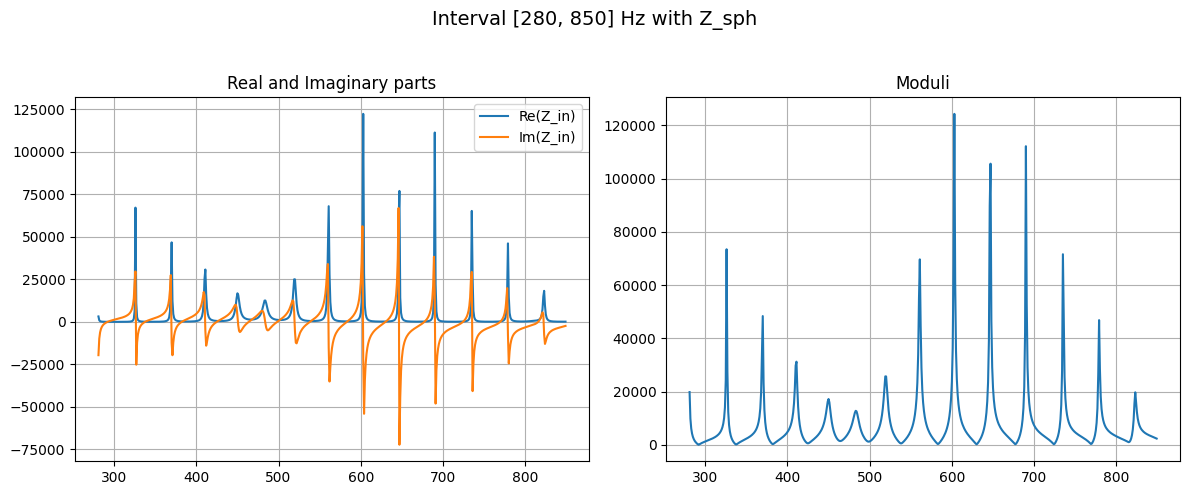

In [16]:
# Middle mesh

p_a = fem.Function(V)
p_a.name = "pressure"

problem = LinearProblem(
    a,
    L,
    u=p_a,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    form_compiler_options={"scalar_type": "complex"},
)

# Define area and pressure at the inlet (symbolic form)
area_form = fem.form(1.0 * ds(2))
pressure_form = fem.form(p_a * ds(2))

# Define arrays to store impedance values
Z_in_real = []
Z_in_imag = []
Z_moduli = []

ii = 0
for f in freqs:
    omega = 2 * np.pi * f
    k.value = omega / c
    
    problem.solve()

    # Integrate pressure over inlet
    p_integral = fem.assemble_scalar(pressure_form)
    p_integral = domain.comm.allreduce(p_integral, op=MPI.SUM)

    # Integrate area over inlet
    inlet_area = fem.assemble_scalar(area_form)
    inlet_area = domain.comm.allreduce(inlet_area, op=MPI.SUM)

    # Compute average pressure at inlet
    p_avg = p_integral / inlet_area

    # Since u_n = 1 m/s, Z_in = p_avg / u_n = p_avg
    Z_in_real.append(p_avg.real)
    Z_in_imag.append(p_avg.imag)
    Z_moduli.append(abs(p_avg))
    print(ii)
    ii = ii+1

# First subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(freqs, Z_in_real, label="Re(Z_in)")
axs[0].plot(freqs, Z_in_imag, label="Im(Z_in)")
axs[0].set_title('Real and Imaginary parts')
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(freqs, Z_moduli)
axs[1].set_title('Moduli')
axs[1].grid(True)

# Main title for the whole figure
fig.suptitle('Interval [280, 850] Hz with Z_sph', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

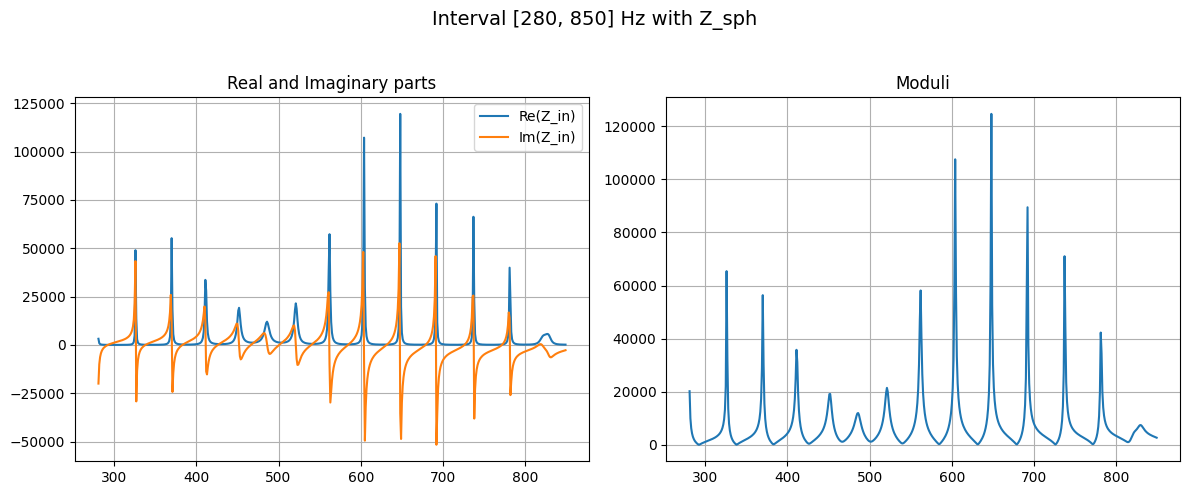

In [23]:
# Coarse mesh

p_a = fem.Function(V)
p_a.name = "pressure"

problem = LinearProblem(
    a,
    L,
    u=p_a,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    form_compiler_options={"scalar_type": "complex"},
)

# Define area and pressure at the inlet (symbolic form)
area_form = fem.form(1.0 * ds(2))
pressure_form = fem.form(p_a * ds(2))

# Define arrays to store impedance values
Z_in_real = []
Z_in_imag = []
Z_moduli = []

ii = 0
for f in freqs:
    omega = 2 * np.pi * f
    k.value = omega / c
    
    problem.solve()

    # Integrate pressure over inlet
    p_integral = fem.assemble_scalar(pressure_form)
    p_integral = domain.comm.allreduce(p_integral, op=MPI.SUM)

    # Integrate area over inlet
    inlet_area = fem.assemble_scalar(area_form)
    inlet_area = domain.comm.allreduce(inlet_area, op=MPI.SUM)

    # Compute average pressure at inlet
    p_avg = p_integral / inlet_area

    # Since u_n = 1 m/s, Z_in = p_avg / u_n = p_avg
    Z_in_real.append(p_avg.real)
    Z_in_imag.append(p_avg.imag)
    Z_moduli.append(abs(p_avg))
    print(ii)
    ii = ii+1

# First subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(freqs, Z_in_real, label="Re(Z_in)")
axs[0].plot(freqs, Z_in_imag, label="Im(Z_in)")
axs[0].set_title('Real and Imaginary parts')
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(freqs, Z_moduli)
axs[1].set_title('Moduli')
axs[1].grid(True)

# Main title for the whole figure
fig.suptitle('Interval [280, 850] Hz with Z_sph', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


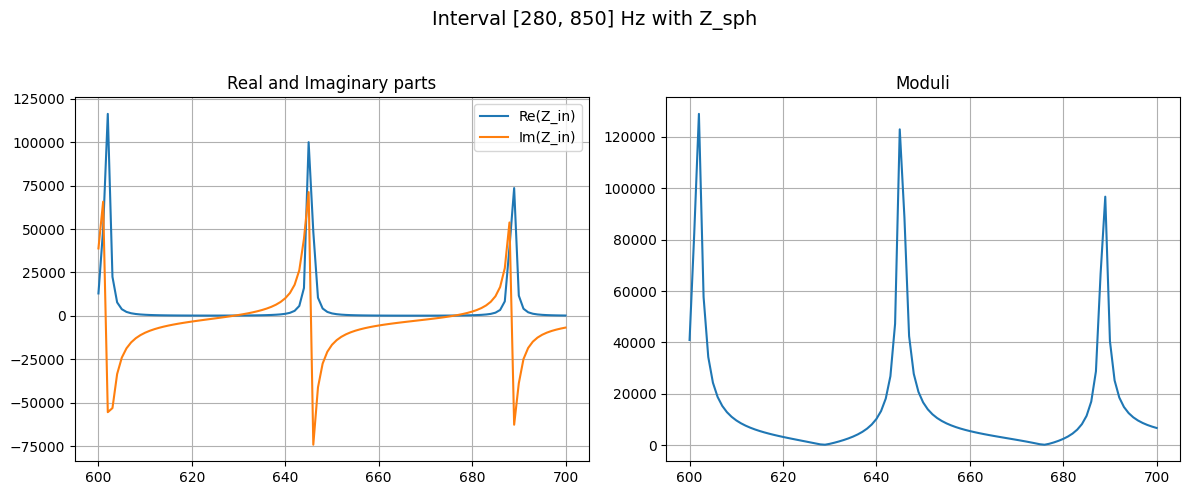

In [8]:
# Fine mesh

p_a = fem.Function(V)
p_a.name = "pressure"

problem = LinearProblem(
    a,
    L,
    u=p_a,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    form_compiler_options={"scalar_type": "complex"},
)

# Define area and pressure at the inlet (symbolic form)
area_form = fem.form(1.0 * ds(2))
pressure_form = fem.form(p_a * ds(2))

# Define arrays to store impedance values
Z_in_real = []
Z_in_imag = []
Z_moduli = []

ii = 0
for f in freqs:
    omega = 2 * np.pi * f
    k.value = omega / c
    
    problem.solve()

    # Integrate pressure over inlet
    p_integral = fem.assemble_scalar(pressure_form)
    p_integral = domain.comm.allreduce(p_integral, op=MPI.SUM)

    # Integrate area over inlet
    inlet_area = fem.assemble_scalar(area_form)
    inlet_area = domain.comm.allreduce(inlet_area, op=MPI.SUM)

    # Compute average pressure at inlet
    p_avg = p_integral / inlet_area

    # Since u_n = 1 m/s, Z_in = p_avg / u_n = p_avg
    Z_in_real.append(p_avg.real)
    Z_in_imag.append(p_avg.imag)
    Z_moduli.append(abs(p_avg))
    print(ii)
    ii = ii+1

# First subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(freqs, Z_in_real, label="Re(Z_in)")
axs[0].plot(freqs, Z_in_imag, label="Im(Z_in)")
axs[0].set_title('Real and Imaginary parts')
axs[0].legend()
axs[0].grid(True)

# Second subplot
axs[1].plot(freqs, Z_moduli)
axs[1].set_title('Moduli')
axs[1].grid(True)

# Main title for the whole figure
fig.suptitle('Interval [280, 850] Hz with Z_sph', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()

In [9]:
with open('moduli_mid_fine_600_700.txt', 'w') as f1:
    for item in Z_moduli:
        f1.write(f"{item}\n")

In [ ]:
with io.XDMFFile(MPI.COMM_WORLD, "solution_complex_right.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(p_a)

In [22]:
# Find frequencies (coarse)
with open("moduli_mid_coarse.txt", "r") as file:
    Z_mod = [float(line.strip()) for line in file if line.strip()]

peaks, _ = find_peaks(Z_mod)
# resonance_freqs = [(i, Z_mod[i]) for i in peaks]
resonance_freqs = peaks + freqs[0]
resonance_freqs

array([326, 370, 411, 452, 486, 521, 562, 604, 648, 692, 737, 781, 829])

In [6]:
# Find frequencies (middle)
with open("moduli_mid_middle_281_850.txt", "r") as file:
    Z_mod = [float(line.strip()) for line in file if line.strip()]

peaks, _ = find_peaks(Z_mod)
# resonance_freqs = [(i, Z_mod[i]) for i in peaks]
resonance_freqs = peaks + 281
resonance_freqs

array([326, 370, 411, 450, 483, 519, 561, 603, 647, 690, 735, 779, 823])

In [23]:
# Find frequencies (fine)
with open("moduli_mid_fine_600_700.txt", "r") as file:
    Z_mod = [float(line.strip()) for line in file if line.strip()]

peaks, _ = find_peaks(Z_mod)
# resonance_freqs = [(i, Z_mod[i]) for i in peaks]
resonance_freqs = peaks + 600
resonance_freqs

array([602, 645, 689])

Gerald Pot [effective note (error wrt wanted note)]:


28 mm: [309 (-22), 371, 417, 465 (-3), 554 (-2)]

32 mm:[321 (-10), 371, 417, 458 (-10), 556] QUESTA

      [326, 370, 411, 450, 483, 519, 561, 603, 647, 690, 735, 779, 823]

input velocity and mesh radius: fare test intervalli +-10 Hz (per radius, check convergenza)
Da pot: minipresentazione divulgativa, A3 con stampe simulazioni, domandare di preparare una misura delle note, misurazione decibell, capire shape delle frequenze

mesh con e senza bocchino (per capire input velocity)

routine con dati diversi centerline e raggi